In [5]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os
sys.path.append(os.path.expanduser('~/PYTHON/ATP/'))
import ceo
import yaml
import pandas as pd
import numpy as np
import atp
import matplotlib.pyplot as plt

from astropy.units import Quantity
from astropy.time import Time
import astropy.io.fits as pyfits

def gmtstatetomodes(gmt):
    state = gmt.state
    modes = np.zeros(82)

    M1Txyz = np.reshape(state['M1']['Txyz'],21)
    modes[[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62,72,73,74]] = M1Txyz

    M2Txyz = np.reshape(state['M2']['Txyz'],21)
    modes[[6,7,8,18,19,20,30,31,32,42,43,44,54,55,56,66,67,68,77,78,79]] = M2Txyz

    M1Rxyz = np.reshape(state['M1']['Rxyz'],21)
    modes[[3,4,5,15,16,17,27,28,29,39,40,41,51,52,53,63,64,65,75,76]] = M1Rxyz[0:20]

    M2Rxyz = np.reshape(state['M2']['Rxyz'],21)
    modes[[9,10,11,21,22,23,33,34,35,45,46,47,57,58,59,69,70,71,80,81]] = M2Rxyz[0:20]

    return modes

def modestogmtstate(gmt,modes):
    state = gmt.state

    M1Txyz = modes[[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62,72,73,74]]
    state['M1']['Txyz'] = np.reshape(M1Txyz,(7,3))

    M2Txyz = modes[[6,7,8,18,19,20,30,31,32,42,43,44,54,55,56,66,67,68,77,78,79]]
    state['M2']['Txyz'] = np.reshape(M2Txyz,(7,3))

    M1Rxyz = np.zeros(21)
    M1Rxyz[0:20] = modes[[3,4,5,15,16,17,27,28,29,39,40,41,51,52,53,63,64,65,75,76]]
    state['M1']['Rxyz'] = np.reshape(M1Rxyz,(7,3))

    M2Rxyz = np.zeros(21)
    M2Rxyz[0:20] = modes[[9,10,11,21,22,23,33,34,35,45,46,47,57,58,59,69,70,71,80,81]]
    state['M2']['Rxyz'] = np.reshape(M2Rxyz,(7,3))
    gmt^=state

L=25.5
nLenslet = 24
threshold = 0.5 # subaperture flux threshold

girmode = "tracking"
config = "dgwf"
saveresults = 0

# load the data about the observation
data = pyfits.getdata(os.path.expanduser('~/PYTHON/AGWS/SAO/weather_pointing_data.fits'))
temperature = data[:,0] # Temperature draw in deg C
pressure = data[:,1] # Pressure draw in mbar
humidity = data[:,2] # Relative humidity in %
windspeed = data[:,3] # Wind speed in m/s
winddir = data[:,4] # Wind direction in degrees
datetime = data[:,5] # Date vector (Clay is first 500, Baade is second 500)
scira = data[:,6] # RA vector (degrees; Clay is first 500, Baade is second 500)
scidec = data[:,7] #  Declination vector (degrees; Clay is first 500, Baade is second 500)
telaz = data[:,8] # Azimuth angle of telescope (degrees; Clay is first 500, Baade is second 500)
telel = data[:,9] # Elevation angle of telescope (degrees; Clay is first 500, Baade is second 500)
r0 = data[:,10] # r0 (cm)
L0 = data[:,11] # L0 (m)

gmt = ceo.GMT_MX()

pupil_size = 25.5
N_SIDE_LENSLET = 24 # The linear size of the lenslet array (>=1).
N_PX_LENSLET = 24 # The sampling in pixel of one lenslet.
d = pupil_size/N_SIDE_LENSLET # The lenslet pitch [m].
DFT_osf = 2 # [2] optional The oversampling factor for the DFT
N_PX_IMAGE = N_PX_LENSLET*DFT_osf # int, optional The sampling in pixel of the imagelet [N_PX_LENSLET]
BIN_IMAGE = 6 # optional The binning factor of the imagelet [1]
N_GS = 1 # optional The number of guide stars [1]
exposureTime = 0.005 
readOutNoiseRms = 0.56
noiseFactor = np.sqrt(2.)
sky_magnitude = 19.2

gs_wavelength = 715e-9
r0_wavelength = 500e-9

savefilename = config+'_tt7err.fits'
try:
    results = pyfits.getdata(savefilename)
except:
    results = np.zeros(1000)

results_mag = np.zeros(1000)

for fieldno in range(0,1000):

    telzen = (90-telel[fieldno])*np.pi/180.
    airmass = 1./np.cos(telzen)

    zeropoint_correction = 16.9e9 / 24.46e9
    atmospheric_throughput = 0.96**airmass 
    if config == "dgwf":
        telescope_throughput = 0.589 
    else:
        telescope_throughput = 0.724
    agws_throughput = 0.75
    dust_throughput = 0.90
    quantum_efficiency = 0.65 # quantum efficiency    
        
    photoElectronGain = zeropoint_correction*atmospheric_throughput*telescope_throughput*agws_throughput*dust_throughput*quantum_efficiency

    r0_val = r0[fieldno]
    r0_val *= atp.r0_scaling(r0_wavelength,gs_wavelength,telzen)
    seeing_rad = gs_wavelength/r0_val
    seeing_arcsec = seeing_rad*ceo.constants.RAD2ARCSEC
    print("seeing (arcsec) : %5.3f" %seeing_arcsec)

    gsfilename = os.path.expanduser('~/')+f'PYTHON/AGWS/Fields/{config}_asterism_{fieldno:04d}.csv'

    # read the field
    try:
        gsdata = pd.read_csv(gsfilename)
    except:
        if config == "dgwf":
            # if there is no DGWF file, use the DGNF one instead
            gsfilename = os.path.expanduser('~/')+f'PYTHON/AGWS/Fields/dgnf_asterism_{fieldno:04d}.csv'
            gsdata = pd.read_csv(gsfilename)
            
    probefunction = gsdata['Probe function'].values
    vismag = gsdata['Visible magnitude'].values
    xpos = gsdata['xpos'].values
    ypos = gsdata['ypos'].values

    tt7probe = np.where(probefunction == 'tt7')
    vismag = vismag[tt7probe]
    xpos = xpos[tt7probe]
    ypos = ypos[tt7probe]

    results_mag[fieldno] = vismag
    print('fieldno = ', fieldno, 'mag = ', vismag)
    
    zen = np.hypot(xpos,ypos)/3600.*np.pi/180 # radial distance in radians
    azi = np.arctan2(ypos,xpos) # azimuth in radians

    wfs_prms = {'N_SIDE_LENSLET':N_SIDE_LENSLET,'N_PX_LENSLET':N_PX_LENSLET,'d':d,'DFT_osf':DFT_osf,'N_PX_IMAGE':N_PX_IMAGE,'BIN_IMAGE':BIN_IMAGE,'N_GS': N_GS,'readOutNoiseRms':readOutNoiseRms,'noiseFactor':noiseFactor,'photoElectronGain':photoElectronGain, 'exposureTime':exposureTime,'intensityThreshold':0.0}
    wfs = ceo.ShackHartmann(**wfs_prms)

    gs = ceo.Source(photometric_band="R+I",zenith=zen,azimuth=azi,magnitude=vismag,rays_box_size=pupil_size,rays_box_sampling=N_SIDE_LENSLET*N_PX_LENSLET+1,rays_origin=[0,0,25])

    ~gmt

    # segment tip-tilt interaction matrix (use M2)
    gs.reset()
    gmt.reset()
    gmt.propagate(gs)
    wfs.calibrate(gs,threshold)
    gs>>(gmt,wfs)

    wfs.camera.nBackgroundPhoton = gs.nBackgroundPhoton(sky_magnitude)*11.42 # fudge factor of 11.42 to get the right values (see tt7photometry)

    simatm = 0 # simulate atmosphere or simply use
    if simatm == 0:
        # make the source larger to emulate atmospheric turbulence
        fwhm_arcsec = np.sqrt(0.25**2+seeing_arcsec**2)
    else:
        fwhm_arcsec = 0.25
    
    unbinned_pixel_scale_arcsec = wfs.pixel_scale_arcsec/BIN_IMAGE
    gs.fwhm = fwhm_arcsec/unbinned_pixel_scale_arcsec
 
    nmes = len(wfs.get_measurement())
    poke = 5e-6
    nmodes = 82
    H = np.zeros((nmes,nmodes))

    ~gmt
    for k in range(nmodes):
        modes = np.zeros(nmodes)
        modes[k] = poke
        modestogmtstate(gmt,modes)
        ~wfs
        gs>>(gmt,wfs)
        +gs
        +wfs
        mes1 = wfs.get_measurement()
        H[:,k] = mes1/poke

    # since we are going to compensate with M2 segment tip-tilt, we want to reconstruct M2 Rxy only!
    M2Rxy = [9,10,21,22,33,34,45,46,57,58,69,70,80,81]
    H7 = H[:,M2Rxy]

    nmes7 = len(mes1)
    cMat7 = np.linalg.solve(np.transpose(H7)@H7,np.transpose(H7))

    # reconstruct global tip-tilt to find the magnitude of the M2 ASM tip-tilt modes
    nvl = np.sum(wfs.valid_lenslet.f.host(shape=(N_GS,N_SIDE_LENSLET**2))>0,axis=1)[0]
    
    cent = np.zeros(2*nvl)
    cent[0:nvl] = 1./206265.
    mx = cMat7@cent
    arcsec2mode = np.sqrt(np.sum(mx**2)/7.)
    mode2arcsec = 1./arcsec2mode

    # an M2Rxy mode leads to 0.2466 arcsec of geometric centroids
    # mode2arcsec = 0.2466

    # check for saturation
    ~wfs
    gs>>(gmt,wfs)
    +gs
    +wfs
    frame = np.array(wfs.camera.ghost_frame[:wfs.N_PX_FRAME,:])

    maxEM = 145e3/np.max(frame)
    EM = np.clip(maxEM,1,200)
    
    readOutNoiseRms = 0.1+100./EM
    wfs.camera.readOutNoiseRms = readOutNoiseRms
        
    # add turbulence, aberrations (FWHM=0.25, DAR)
    # look at TurbulenceSimulation.py to see how turbulence is added

    ~gmt    
    modeerr = np.zeros((14,100))
    centerr = np.zeros((2*nvl,100))
    for k1 in range(100):
        ~wfs
        gs>>(gmt,wfs)
        +gs
        +wfs
        mes = wfs.get_measurement()
        centerr[:,k1] = mes
        modeerr[:,k1] = cMat7@mes

    # calculate the standard deviation of each mode
    moderms = np.std(modeerr,axis=1)
    tt7rms_arcsec = np.sqrt(np.mean(moderms**2))*mode2arcsec
    print('error along each axis (arcsec)',tt7rms_arcsec)
    results[fieldno] = tt7rms_arcsec
if saveresults:
    pyfits.PrimaryHDU(results).writeto(savefilename,overwrite=True)
print('DONE')

seeing (arcsec) : 0.757
fieldno =  0 mag =  [9.77749988]
error along each axis (arcsec) 0.001335467311463264
seeing (arcsec) : 0.394
fieldno =  1 mag =  [11.0343437]
error along each axis (arcsec) 0.003077879274612987
seeing (arcsec) : 0.913
fieldno =  2 mag =  [10.3116875]
error along each axis (arcsec) 0.0018630519712523222
seeing (arcsec) : 0.526
fieldno =  3 mag =  [5.09835901]
error along each axis (arcsec) 0.00036908130885596695
seeing (arcsec) : 0.727
fieldno =  4 mag =  [11.18889889]
error along each axis (arcsec) 0.003834310397571918
seeing (arcsec) : 1.286
fieldno =  5 mag =  [9.16250086]
error along each axis (arcsec) 0.0010078198048703625
seeing (arcsec) : 0.540
fieldno =  6 mag =  [9.48277983]
error along each axis (arcsec) 0.0011141548428643606
seeing (arcsec) : 1.118
fieldno =  7 mag =  [12.44824049]
error along each axis (arcsec) 0.005631747614673935
seeing (arcsec) : 1.022
fieldno =  8 mag =  [9.71731013]
error along each axis (arcsec) 0.0013360686103117065
seeing (arc

error along each axis (arcsec) 0.0040814901970324105
seeing (arcsec) : 0.803
fieldno =  75 mag =  [10.78586269]
error along each axis (arcsec) 0.002535644712854445
seeing (arcsec) : 0.712
fieldno =  76 mag =  [10.67499125]
error along each axis (arcsec) 0.002679983734128127
seeing (arcsec) : 1.484
fieldno =  77 mag =  [11.64439568]
error along each axis (arcsec) 0.004086406466407821
seeing (arcsec) : 0.908
fieldno =  78 mag =  [10.53709196]
error along each axis (arcsec) 0.002295052744350148
seeing (arcsec) : 0.775
fieldno =  79 mag =  [11.50148049]
error along each axis (arcsec) 0.0037662107849767436
seeing (arcsec) : 0.756
fieldno =  80 mag =  [12.08929265]
error along each axis (arcsec) 0.0045466564405948545
seeing (arcsec) : 0.436
fieldno =  81 mag =  [8.40041493]
error along each axis (arcsec) 0.0007252384405868786
seeing (arcsec) : 0.379
fieldno =  82 mag =  [5.86597907]
error along each axis (arcsec) 0.0004341727380970318
seeing (arcsec) : 0.521
fieldno =  83 mag =  [9.58201613]

error along each axis (arcsec) 0.0009495575899383514
seeing (arcsec) : 1.257
fieldno =  149 mag =  [9.35921913]
error along each axis (arcsec) 0.0011286441960310512
seeing (arcsec) : 0.441
fieldno =  150 mag =  [10.42309204]
error along each axis (arcsec) 0.002091838978711669
seeing (arcsec) : 0.752
fieldno =  151 mag =  [10.13346782]
error along each axis (arcsec) 0.0017388023867839547
seeing (arcsec) : 0.914
fieldno =  152 mag =  [10.24469964]
error along each axis (arcsec) 0.0019200380295652892
seeing (arcsec) : 0.767
fieldno =  153 mag =  [12.75835512]
error along each axis (arcsec) 0.005338902341974383
seeing (arcsec) : 0.863
fieldno =  154 mag =  [9.39804509]
error along each axis (arcsec) 0.0010564844669661718
seeing (arcsec) : 0.592
fieldno =  155 mag =  [11.48409968]
error along each axis (arcsec) 0.003949442361325049
seeing (arcsec) : 0.731
fieldno =  156 mag =  [8.63412826]
error along each axis (arcsec) 0.0007954523169124868
seeing (arcsec) : 0.447
fieldno =  157 mag =  [10

error along each axis (arcsec) 0.0027986274874104997
seeing (arcsec) : 0.590
fieldno =  223 mag =  [10.84933695]
error along each axis (arcsec) 0.00277682719072246
seeing (arcsec) : 1.158
fieldno =  224 mag =  [10.51285332]
error along each axis (arcsec) 0.0023591978571911388
seeing (arcsec) : 0.988
fieldno =  225 mag =  [12.76780024]
error along each axis (arcsec) 0.005583845971244202
seeing (arcsec) : 0.917
fieldno =  226 mag =  [7.59187429]
error along each axis (arcsec) 0.000639062988295598
seeing (arcsec) : 0.352
fieldno =  227 mag =  [11.60863702]
error along each axis (arcsec) 0.0038263375663821256
seeing (arcsec) : 0.669
fieldno =  228 mag =  [11.28551334]
error along each axis (arcsec) 0.0031964834553405972
seeing (arcsec) : 0.621
fieldno =  229 mag =  [11.17491707]
error along each axis (arcsec) 0.0032747633097058916
seeing (arcsec) : 0.452
fieldno =  230 mag =  [10.74563147]
error along each axis (arcsec) 0.00272471900483049
seeing (arcsec) : 0.508
fieldno =  231 mag =  [9.0

error along each axis (arcsec) 0.001941036842503365
seeing (arcsec) : 0.528
fieldno =  297 mag =  [8.74602233]
error along each axis (arcsec) 0.0008094946666335312
seeing (arcsec) : 0.832
fieldno =  298 mag =  [10.50606895]
error along each axis (arcsec) 0.0020716708941565386
seeing (arcsec) : 0.899
fieldno =  299 mag =  [10.75025756]
error along each axis (arcsec) 0.002637140495512355
seeing (arcsec) : 1.063
fieldno =  300 mag =  [9.75589292]
error along each axis (arcsec) 0.001378959261079011
seeing (arcsec) : 0.807
fieldno =  301 mag =  [11.28049634]
error along each axis (arcsec) 0.0034282351427160447
seeing (arcsec) : 1.497
fieldno =  302 mag =  [8.14540441]
error along each axis (arcsec) 0.0007073280125556199
seeing (arcsec) : 0.998
fieldno =  303 mag =  [10.09176916]
error along each axis (arcsec) 0.0017176291842762345
seeing (arcsec) : 0.996
fieldno =  304 mag =  [11.46213281]
error along each axis (arcsec) 0.004035043411854686
seeing (arcsec) : 0.845
fieldno =  305 mag =  [10.

error along each axis (arcsec) 0.0009108200175287918
seeing (arcsec) : 0.727
fieldno =  371 mag =  [11.14294835]
error along each axis (arcsec) 0.003301060252685758
seeing (arcsec) : 0.719
fieldno =  372 mag =  [11.95325394]
error along each axis (arcsec) 0.004268901595151508
seeing (arcsec) : 0.825
fieldno =  373 mag =  [9.3381473]
error along each axis (arcsec) 0.0010267917598762411
seeing (arcsec) : 0.671
fieldno =  374 mag =  [8.79583501]
error along each axis (arcsec) 0.000816994087635504
seeing (arcsec) : 1.273
fieldno =  375 mag =  [6.30923183]
error along each axis (arcsec) 0.0004893252549621976
seeing (arcsec) : 0.982
fieldno =  376 mag =  [10.22433989]
error along each axis (arcsec) 0.0018184105055054258
seeing (arcsec) : 0.388
fieldno =  377 mag =  [10.61484498]
error along each axis (arcsec) 0.0024819729193228256
seeing (arcsec) : 0.931
fieldno =  378 mag =  [12.26084655]
error along each axis (arcsec) 0.005681879993476297
seeing (arcsec) : 0.951
fieldno =  379 mag =  [8.00

error along each axis (arcsec) 0.005333952410681276
seeing (arcsec) : 0.655
fieldno =  445 mag =  [10.2426774]
error along each axis (arcsec) 0.001856599133623744
seeing (arcsec) : 0.953
fieldno =  446 mag =  [6.14325034]
error along each axis (arcsec) 0.0004316751816873432
seeing (arcsec) : 0.843
fieldno =  447 mag =  [8.10155646]
error along each axis (arcsec) 0.0006628825641385284
seeing (arcsec) : 0.783
fieldno =  448 mag =  [8.76186425]
error along each axis (arcsec) 0.0007993579007524503
seeing (arcsec) : 0.579
fieldno =  449 mag =  [10.52812873]
error along each axis (arcsec) 0.0022007304721839236
seeing (arcsec) : 1.095
fieldno =  450 mag =  [11.11177015]
error along each axis (arcsec) 0.0032318170792533236
seeing (arcsec) : 0.765
fieldno =  451 mag =  [10.20489427]
error along each axis (arcsec) 0.0018468548415732672
seeing (arcsec) : 0.618
fieldno =  452 mag =  [8.07093396]
error along each axis (arcsec) 0.0006564187380389189
seeing (arcsec) : 0.594
fieldno =  453 mag =  [11.

error along each axis (arcsec) 0.0010453188888669767
seeing (arcsec) : 0.812
fieldno =  519 mag =  [9.54961741]
error along each axis (arcsec) 0.0011991058454805012
seeing (arcsec) : 0.618
fieldno =  520 mag =  [11.39824984]
error along each axis (arcsec) 0.003845703675075881
seeing (arcsec) : 0.802
fieldno =  521 mag =  [11.87784305]
error along each axis (arcsec) 0.004615147366315449
seeing (arcsec) : 1.102
fieldno =  522 mag =  [9.82824442]
error along each axis (arcsec) 0.0015062811177838982
seeing (arcsec) : 0.812
fieldno =  523 mag =  [9.17605668]
error along each axis (arcsec) 0.0009211598879496486
seeing (arcsec) : 1.074
fieldno =  524 mag =  [10.53988333]
error along each axis (arcsec) 0.0022899738441527965
seeing (arcsec) : 0.939
fieldno =  525 mag =  [8.7456682]
error along each axis (arcsec) 0.0008227075287574671
seeing (arcsec) : 0.763
fieldno =  526 mag =  [13.93312716]
error along each axis (arcsec) 0.005870190608232783
seeing (arcsec) : 0.782
fieldno =  527 mag =  [12.4

error along each axis (arcsec) 0.0044506550417146755
seeing (arcsec) : 0.942
fieldno =  593 mag =  [10.02540122]
error along each axis (arcsec) 0.0016123544170224097
seeing (arcsec) : 0.688
fieldno =  594 mag =  [10.16805659]
error along each axis (arcsec) 0.0018887179079419623
seeing (arcsec) : 0.919
fieldno =  595 mag =  [11.04226815]
error along each axis (arcsec) 0.00323245792872199
seeing (arcsec) : 0.411
fieldno =  596 mag =  [8.5473379]
error along each axis (arcsec) 0.000758826615801082
seeing (arcsec) : 0.816
fieldno =  597 mag =  [11.52252195]
error along each axis (arcsec) 0.0034649210588933166
seeing (arcsec) : 0.632
fieldno =  598 mag =  [12.26854143]
error along each axis (arcsec) 0.004283036408665698
seeing (arcsec) : 0.907
fieldno =  599 mag =  [10.41692407]
error along each axis (arcsec) 0.0023285232674418004
seeing (arcsec) : 0.516
fieldno =  600 mag =  [10.88403118]
error along each axis (arcsec) 0.0029994132246850074
seeing (arcsec) : 0.575
fieldno =  601 mag =  [11

error along each axis (arcsec) 0.0020967320039932276
seeing (arcsec) : 1.081
fieldno =  667 mag =  [6.73148571]
error along each axis (arcsec) 0.000508444182693065
seeing (arcsec) : 0.890
fieldno =  668 mag =  [12.15220085]
error along each axis (arcsec) 0.004636376428155222
seeing (arcsec) : 0.848
fieldno =  669 mag =  [11.27612488]
error along each axis (arcsec) 0.003297991281817796
seeing (arcsec) : 0.631
fieldno =  670 mag =  [13.69804048]
error along each axis (arcsec) 0.005043068697597664
seeing (arcsec) : 0.589
fieldno =  671 mag =  [11.86113847]
error along each axis (arcsec) 0.004612530624056452
seeing (arcsec) : 0.735
fieldno =  672 mag =  [10.85431837]
error along each axis (arcsec) 0.002834792178680019
seeing (arcsec) : 0.627
fieldno =  673 mag =  [7.95101994]
error along each axis (arcsec) 0.0006376411212937097
seeing (arcsec) : 0.722
fieldno =  674 mag =  [10.49352473]
error along each axis (arcsec) 0.0020772587098404557
seeing (arcsec) : 1.219
fieldno =  675 mag =  [8.87

error along each axis (arcsec) 0.001441089507440913
seeing (arcsec) : 0.784
fieldno =  741 mag =  [9.43767373]
error along each axis (arcsec) 0.0010715625158482312
seeing (arcsec) : 0.637
fieldno =  742 mag =  [10.46048062]
error along each axis (arcsec) 0.002124643902062873
seeing (arcsec) : 0.944
fieldno =  743 mag =  [12.58090558]
error along each axis (arcsec) 0.005498783551286129
seeing (arcsec) : 0.724
fieldno =  744 mag =  [10.11602821]
error along each axis (arcsec) 0.001670722606784734
seeing (arcsec) : 0.559
fieldno =  745 mag =  [9.21324947]
error along each axis (arcsec) 0.0009873892123713822
seeing (arcsec) : 0.768
fieldno =  746 mag =  [10.26060908]
error along each axis (arcsec) 0.00189816855868128
seeing (arcsec) : 0.388
fieldno =  747 mag =  [8.83420375]
error along each axis (arcsec) 0.0008046375378913268
seeing (arcsec) : 0.717
fieldno =  748 mag =  [10.14920004]
error along each axis (arcsec) 0.001702948649884695
seeing (arcsec) : 0.887
fieldno =  749 mag =  [12.271

error along each axis (arcsec) 0.002043814834392436
seeing (arcsec) : 0.580
fieldno =  815 mag =  [9.62349028]
error along each axis (arcsec) 0.0011695664007416843
seeing (arcsec) : 0.916
fieldno =  816 mag =  [11.57116431]
error along each axis (arcsec) 0.0039973705997326855
seeing (arcsec) : 0.774
fieldno =  817 mag =  [13.74565063]
error along each axis (arcsec) 0.0054366707207164425
seeing (arcsec) : 0.458
fieldno =  818 mag =  [12.31058277]
error along each axis (arcsec) 0.00499923250492465
seeing (arcsec) : 0.593
fieldno =  819 mag =  [11.66483881]
error along each axis (arcsec) 0.004489513621177321
seeing (arcsec) : 0.494
fieldno =  820 mag =  [12.26462859]
error along each axis (arcsec) 0.004285948740913188
seeing (arcsec) : 0.472
fieldno =  821 mag =  [10.20018774]
error along each axis (arcsec) 0.0016764450850330437
seeing (arcsec) : 0.870
fieldno =  822 mag =  [10.61027568]
error along each axis (arcsec) 0.0025005410169805175
seeing (arcsec) : 0.766
fieldno =  823 mag =  [7.

error along each axis (arcsec) 0.0047223245222000635
seeing (arcsec) : 0.557
fieldno =  889 mag =  [10.65379204]
error along each axis (arcsec) 0.002272765881164366
seeing (arcsec) : 0.692
fieldno =  890 mag =  [11.4322386]
error along each axis (arcsec) 0.003403441303774961
seeing (arcsec) : 0.583
fieldno =  891 mag =  [11.83474092]
error along each axis (arcsec) 0.004395825872336803
seeing (arcsec) : 0.799
fieldno =  892 mag =  [12.39279318]
error along each axis (arcsec) 0.0058067220053513125
seeing (arcsec) : 0.737
fieldno =  893 mag =  [12.34186448]
error along each axis (arcsec) 0.005218835185750791
seeing (arcsec) : 1.280
fieldno =  894 mag =  [10.46933628]
error along each axis (arcsec) 0.002122275000917954
seeing (arcsec) : 0.625
fieldno =  895 mag =  [10.49263636]
error along each axis (arcsec) 0.0023419389549021222
seeing (arcsec) : 0.682
fieldno =  896 mag =  [8.83458343]
error along each axis (arcsec) 0.0008610927879919216
seeing (arcsec) : 1.223
fieldno =  897 mag =  [10.

error along each axis (arcsec) 0.004686531723587663
seeing (arcsec) : 0.548
fieldno =  962 mag =  [12.58461324]
error along each axis (arcsec) 0.005488774546808568
seeing (arcsec) : 1.011
fieldno =  963 mag =  [11.45863931]
error along each axis (arcsec) 0.004078130420327779
seeing (arcsec) : 0.547
fieldno =  964 mag =  [11.59282787]
error along each axis (arcsec) 0.0040703645509936
seeing (arcsec) : 0.741
fieldno =  965 mag =  [10.88403118]
error along each axis (arcsec) 0.002798143844791972
seeing (arcsec) : 0.615
fieldno =  966 mag =  [7.95101994]
error along each axis (arcsec) 0.00064919915354641
seeing (arcsec) : 0.525
fieldno =  967 mag =  [10.80800779]
error along each axis (arcsec) 0.0027086670969106333
seeing (arcsec) : 0.829
fieldno =  968 mag =  [10.1883969]
error along each axis (arcsec) 0.001943677416305094
seeing (arcsec) : 0.914
fieldno =  969 mag =  [11.36576758]
error along each axis (arcsec) 0.0035103152005974293
seeing (arcsec) : 1.107
fieldno =  970 mag =  [12.40152

In [6]:
results_mag

array([ 9.77749988, 11.0343437 , 10.3116875 ,  5.09835901, 11.18889889,
        9.16250086,  9.48277983, 12.44824049,  9.71731013, 10.72708828,
        8.82857696,  9.99273563, 11.3241532 , 11.18005911,  9.74688101,
       10.24821399,  8.17617924,  9.91552226, 11.68746865,  8.77558104,
       12.38673992, 10.10125501, 12.32629182,  9.19437547, 10.78950269,
        8.49207061, 10.97819364, 11.9520255 ,  9.83703297,  9.75119221,
        9.76627307,  9.79022976, 11.9868727 ,  9.18239826,  6.35395853,
        9.98542987, 10.85608148, 11.28522657, 10.05539674, 11.34375726,
       11.40125632, 11.22905992, 10.74383695, 11.28863127, 11.86662795,
       12.25684171, 10.90136401, 11.1533777 , 10.55273866, 12.07223169,
       12.77562828, 10.49818709, 12.33550481, 12.39583975, 11.48719098,
       10.12194765, 11.03672559,  7.27369791,  8.13312635,  8.74652472,
       11.08069146, 11.74100981, 11.21094323, 10.12264991, 11.00341029,
        8.82196139,  9.97055635, 11.19693703, 12.53399831, 12.06

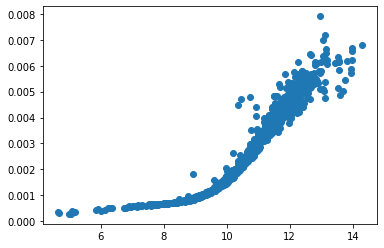

In [7]:
plt.scatter(results_mag, results)